In [1]:
import matplotlib as mpl
from datasets import load_dataset
from genaibook.core import show_images

In [2]:
mpl.rcParams["image.cmap"] = "gray_r"

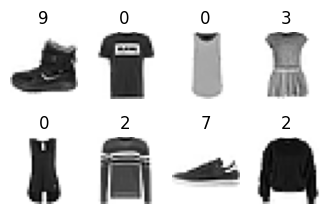

In [3]:
fashion_mnist = load_dataset("fashion_mnist")
clothes = fashion_mnist["train"]['image'][:8]
classes = fashion_mnist["train"]["label"][:8]
show_images(clothes, titles=classes, figsize=(4, 2.5))

In [4]:
import torch
from torchvision import transforms

In [5]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Pad(2), # add 2 pixels to all sides to prevent distortion of edges
        transforms.Normalize([0.5], [0.5]) # Map to (-1, 1)
    ]
)

In [6]:
def transform(examples):
    images = [preprocess(image) for image in examples["image"]]
    return {"images": images, "labels": examples["label"]}

In [7]:
train_dataset = fashion_mnist["train"].with_transform(transform)

In [8]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

# Create a Class Conditioned Model

In [9]:
from diffusers import UNet2DModel

/Users/jorocca/Desktop/Projects/AI Practice/Transformers-Diffusions/.venv/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [10]:
model = UNet2DModel(
    in_channels=1, # 1 channel for greyscale images
    out_channels=1,
    sample_size=32, # image size
    block_out_channels=(32, 64, 128, 256),
    num_class_embeds=10 # Enable class conditioning
)

In [11]:
x = torch.randn((1, 1, 32, 32))
with torch.inference_mode():
    out = model(x, timestep=7, class_labels=torch.tensor([2])).sample
out.shape

torch.Size([1, 1, 32, 32])

## Add noise

In [12]:
from diffusers import DDPMScheduler

In [13]:
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.001, beta_end=0.02
)

In [14]:
timesteps = torch.linspace(0, 999, 8).long()
batch = next(iter(train_dataloader))

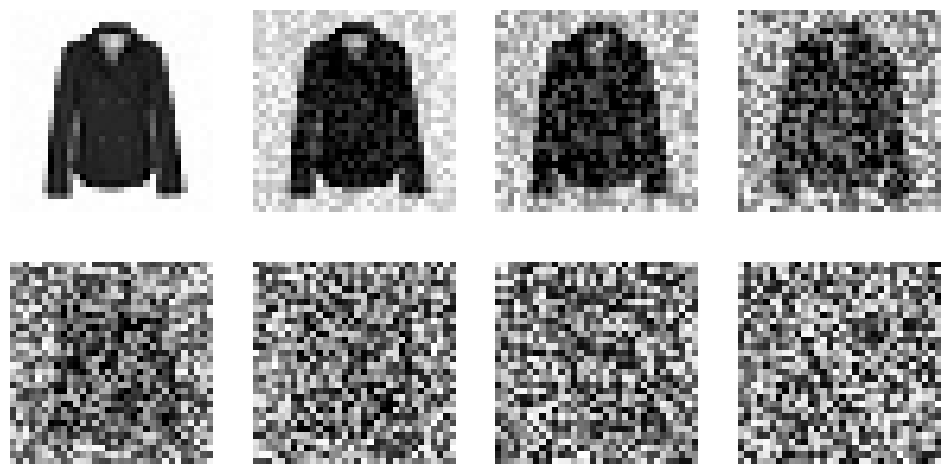

In [15]:
x = batch["images"][0].expand([8, 1, 32, 32])
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

# Le Train

In [16]:
from torch.nn import functional as F
from tqdm import tqdm
from genaibook.core import get_device

In [17]:
scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.0001, beta_end=0.02
)

In [18]:
num_epochs = 25
lr = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
losses = []
device = get_device()
model = model.to(device)

In [19]:
for epoch in (progress := tqdm(range(num_epochs))):
    for step, batch in (
        inner := tqdm(
            enumerate(train_dataloader),
            position=0,
            leave=True,
            total=len(train_dataloader)
        )
    ):
        clean_images = batch['images'].to(device)
        class_labels = batch['labels'].to(device)

        noise = torch.randn(clean_images.shape).to(device)

        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (clean_images.shape[0],),
            device=device
        ).long()

        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(
            noisy_images,
            timesteps,
            class_labels=class_labels,
            return_dict=False
        )[0]

        loss = F.mse_loss(noise_pred, noise)

        inner.set_postfix(loss=f'{loss.cpu().item():3f}')

        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 25/25 [2:17:40<00:00, 330.44s/it]


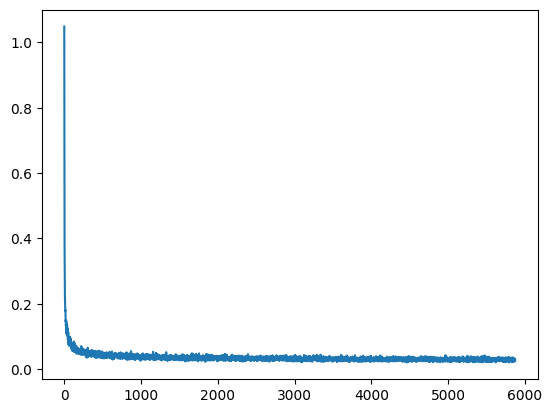

In [20]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [21]:
def generate_from_class(class_to_generate, n_samples=6):
    sample = torch.randn(n_samples, 1, 32, 32).to(device)
    class_labels = [class_to_generate] * n_samples
    class_labels = torch.tensor(class_labels).to(device)

    for _, t in tqdm(enumerate(scheduler.timesteps)):
        with torch.inference_mode():
            noise_pred = model(sample, t, class_labels=class_labels).sample

        sample = scheduler.step(noise_pred, t, sample).prev_sample
    return sample.clip(-1, 1) * 0.5 + 0.5

1000it [00:48, 20.45it/s]


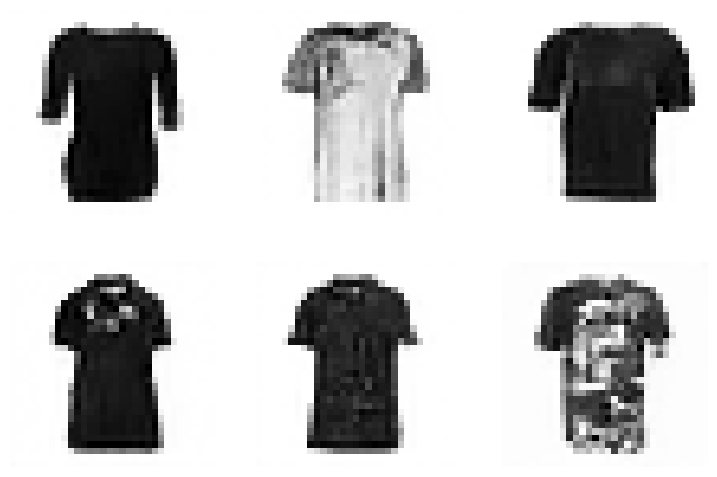

In [22]:
images = generate_from_class(0)
show_images(images, nrows=2)

1000it [00:48, 20.72it/s]


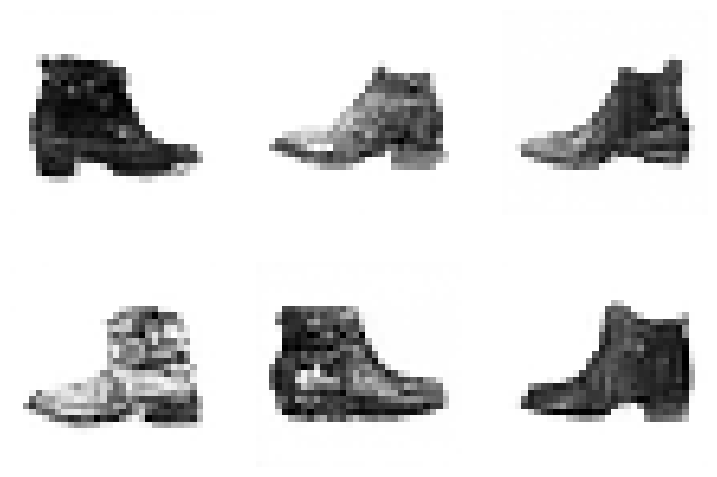

In [23]:
images = generate_from_class(9)
show_images(images, nrows=2)

In [ ]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", 
    torch_dtype=torch.float16, 
    variant="fp16"
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

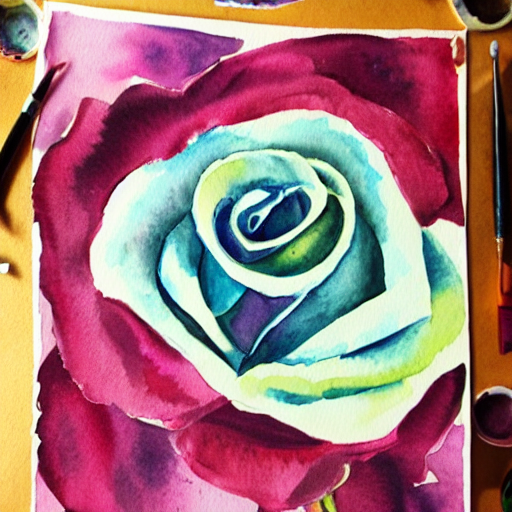

In [29]:
pipe("Watercolor illustration of a rose").images[0]

In [34]:
prompt = "A photograph of a puppy"

text_input = pipe.tokenizer(
    prompt,
    return_tensors="pt"
)

In [35]:
for t in text_input["input_ids"][0]:
    print(t, pipe.tokenizer.decode(t))

tensor(49406) <|startoftext|>
tensor(320) a
tensor(8853) photograph
tensor(539) of
tensor(320) a
tensor(6829) puppy
tensor(49407) <|endoftext|>


In [36]:
text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]
print("Text embeddings shape:", text_embeddings.shape)

Text embeddings shape: torch.Size([1, 7, 768])


<Axes: >

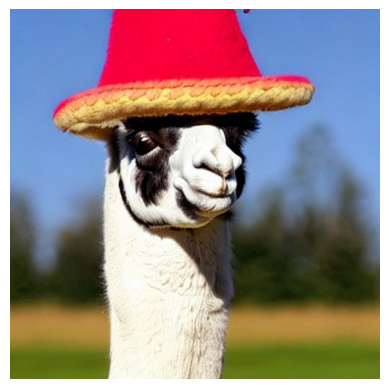

In [37]:
from genaibook.core import load_image, show_image, SampleURL

im = load_image(
    SampleURL.LlamaExample,
    size=(512, 512)
)
show_image(im)

In [ ]:
with torch.inference_mode():
    tensor_im = transforms.ToTensor()(im).unsqueeze(0).to(device) * 2 - 1
    tensor_im = tensor_im.half()

    latent = pipe.vae.encode(tensor_im)

    latents = latent.latent_dist.sample()
    latents = latents * 0.18215 # Scaling factor - same as Stable Diffusion

latents.shape

torch.Size([1, 4, 64, 64])

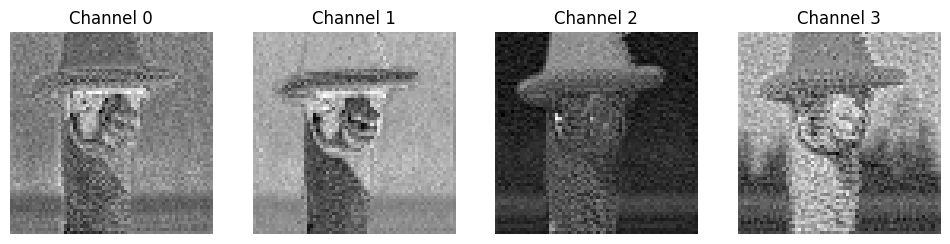

In [39]:
show_images(
    [l for l in latents[0]],
    titles=[f"Channel {i}" for i in range(latents.shape[1])],
    ncols=4
)

<Axes: >

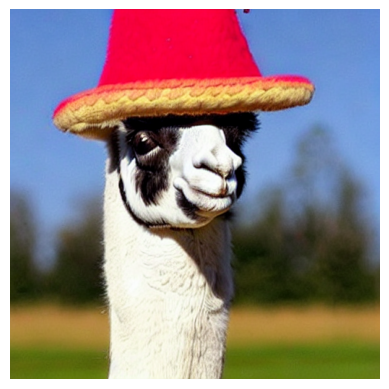

In [41]:
with torch.inference_mode():
    image = pipe.vae.decode(latents / 0.18215).sample
image = (image / 2 + 0.5).clamp(0, 1)
show_image(image[0].float())

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

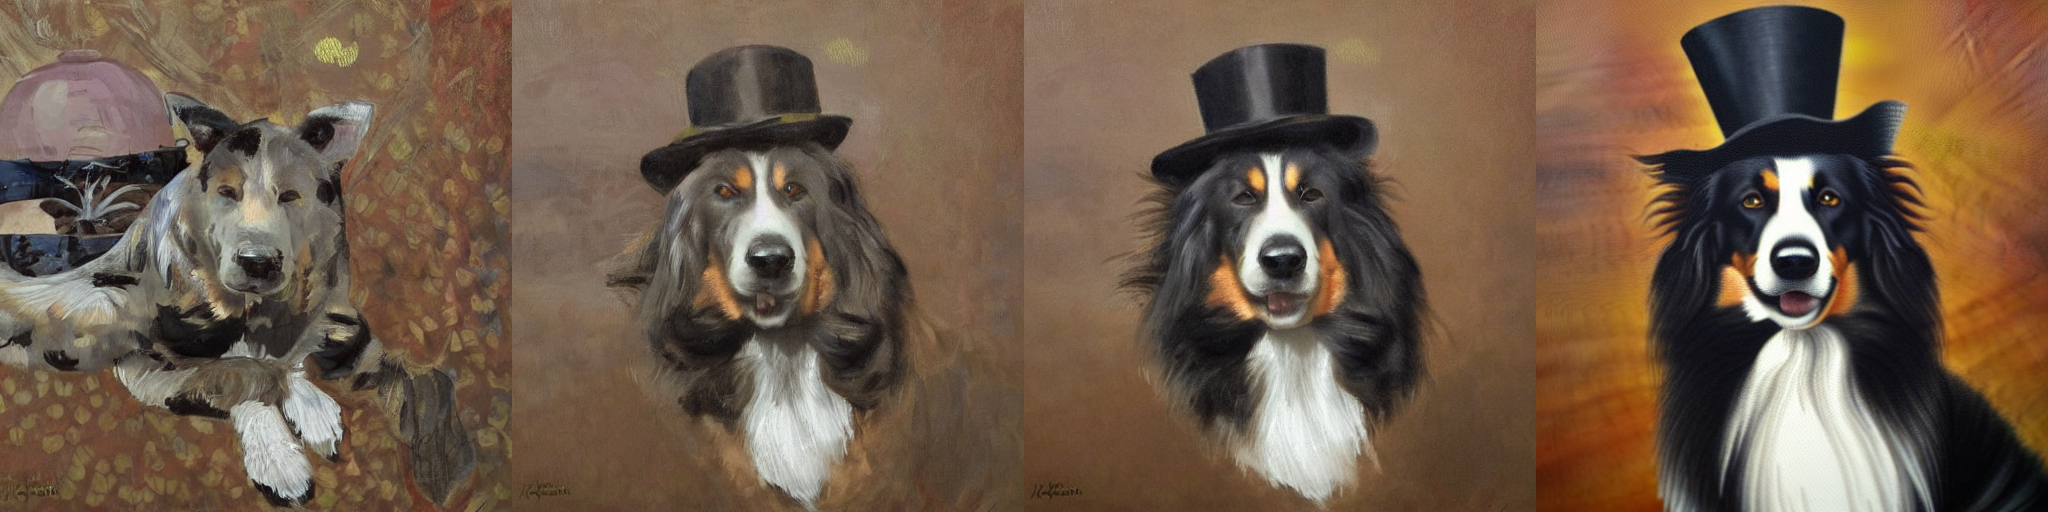

In [42]:
images = []
prompt = "An oil painting of a collie in a top hat"
for guidance_scale in [1, 2, 4, 12]:
    torch.manual_seed(0)
    image = pipe(prompt, guidance_scale=guidance_scale).images[0]
    images.append(image)

from genaibook.core import image_grid

image_grid(images, 1, 4)

In [62]:
prompt = ["Acrylic palette knife painting of a flower"]
height = 512
width = height
num_inference_steps = 30
guidance_scale = 7.5
seed = 40

In [63]:
text_input = pipe.tokenizer(
    prompt,
    padding="max_length",
    return_tensors="pt"
)

uncond_input = pipe.tokenizer(
    "",
    padding="max_length",
    return_tensors="pt"
)

with torch.inference_mode():
    text_embeddings = pipe.text_encoder(text_input.input_ids.to(device))[0]
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [64]:
pipe.scheduler.set_timesteps(num_inference_steps)

latents = (
    torch.randn(
        (1, pipe.unet.config.in_channels, height // 8, width // 8),
    )
    .to(device)
    .half()
)

latents = latents * pipe.scheduler.init_noise_sigma

In [65]:
for t in pipe.scheduler.timesteps:
    latent_input = torch.cat([latents] * 2)
    latent_input = pipe.scheduler.scale_model_input(latent_input, t)

    with torch.inference_mode():
        noise_pred = pipe.unet(
            latent_input, t, encoder_hidden_states=text_embeddings
        ).sample
    
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

    noise_pred = noise_pred_uncond + guidance_scale * (
        noise_pred_text - noise_pred_uncond
    )

    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

<Axes: >

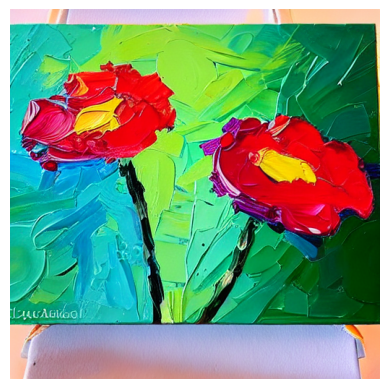

In [66]:
latents = 1 / pipe.vae.config.scaling_factor * latents
with torch.inference_mode():
    image = pipe.vae.decode(latents).sample
image = (image / 2 + 0.5).clamp(0, 1)
show_image(image[0].float())